In [1]:
test_path = "test_df.csv"
val_path = "valid_df.csv"
train_path = "train_df.csv"

import pandas as pd
import numpy as np

train_data_source = pd.read_csv(train_path)
train_data = train_data_source[['text', 'target']]

val_data_source = pd.read_csv(val_path)
val_data = val_data_source[['text', 'target']]

test_data_source = pd.read_csv(test_path)
test_data = test_data_source[['text', 'target']]

test_data

,text,target
0,i’m getting so use to this now unamused_face ...,1
1,"reply to to perform the stretch, fall forward ...",0
2,"it's the small things, p.s these are only joke...",1
3,"women we are so funny. j, women, women, wome...",1
4,"we all waited. alright y'all, this is the ne...",0
...,...,...
190,can i come live with someone else pls? clean t...,1
191,"with walking into my purpose, a new challenge ...",0
192,men are being lazy. you see ladies out here g...,1
193,"xin chào officially, there are 42 offices with...",0


In [2]:

train_texts = train_data['text'].tolist()
train_labels =  train_data['target'].tolist()

test_texts = test_data['text'].tolist()
test_labels =  test_data['target'].tolist()

val_texts = val_data['text'].tolist()
val_labels =  val_data['target'].tolist()



In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np

In [4]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        return_tensors='pt',
        max_length=512
    )

train_encodings = tokenize(train_texts)
test_encodings = tokenize(test_texts)
val_encodings = tokenize(val_texts)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

In [7]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = TextDataset(train_encodings, train_labels)
test_dataset = TextDataset(test_encodings, test_labels)
val_dataset = TextDataset(val_encodings, val_labels)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = RobertaForSequenceClassification.from_pretrained('roberta-large', num_labels=len(set(train_labels)))
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
epochs = 3

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    # --- Training ---
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1} - Training")
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == batch['labels']).sum().item()
        total += batch['labels'].size(0)

        loop.set_postfix(loss=loss.item())

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # --- Validation ---
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} - Validation"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == batch['labels']).sum().item()
            total += batch['labels'].size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# --- Final Test Evaluation ---
model.eval()
test_preds, test_targets = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Final Test Evaluation"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits

        preds = torch.argmax(logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(batch['labels'].cpu().numpy())

test_accuracy = accuracy_score(test_targets, test_preds)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

Epoch 1 - Validation: 100%|██████████| 25/25 [00:16<00:00,  1.50it/s]


[Epoch 1] Train Loss: 0.7167, Train Acc: 0.5334 | Val Loss: 0.6925, Val Acc: 0.4615


Epoch 2 - Validation: 100%|██████████| 25/25 [00:16<00:00,  1.49it/s]


[Epoch 2] Train Loss: 0.6940, Train Acc: 0.5643 | Val Loss: 0.6783, Val Acc: 0.5333


Epoch 3 - Validation: 100%|██████████| 25/25 [00:16<00:00,  1.49it/s]


[Epoch 3] Train Loss: 0.6850, Train Acc: 0.5969 | Val Loss: 0.6996, Val Acc: 0.4308


Final Test Evaluation: 100%|██████████| 25/25 [00:16<00:00,  1.49it/s]

Final Test Accuracy: 0.5128


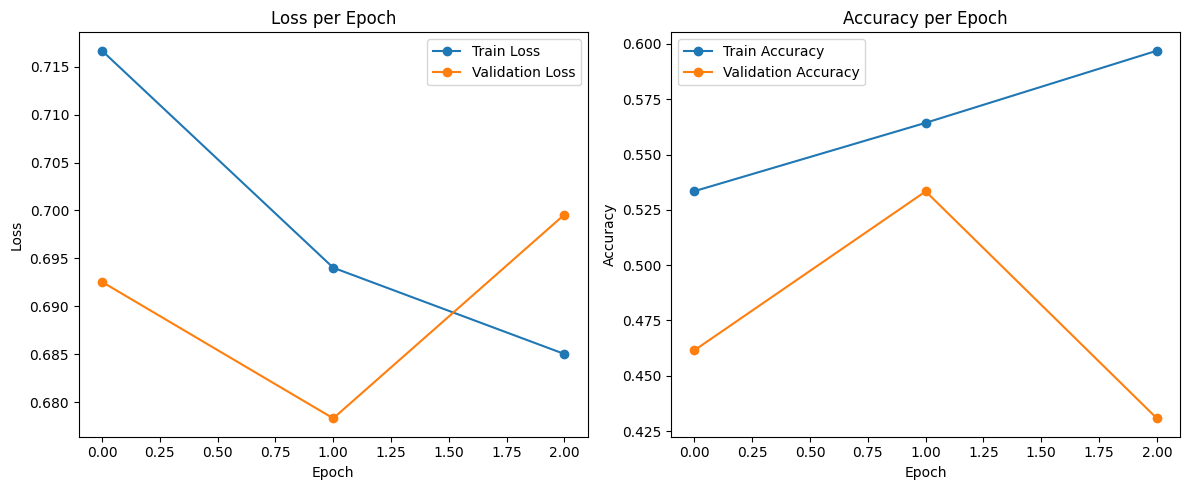

In [11]:
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
import torch
import torch.nn.functional as F

def generate_predictions(model, dataloader):
    model.eval()
    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generating Predictions"):
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            logits = outputs.logits
            probs = F.softmax(logits, dim=1)  # Get probabilities from logits
            preds = torch.argmax(probs, dim=1)  # Get predicted class

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    return np.array(all_probs), np.array(all_preds), np.array(all_labels)


In [15]:
probs, preds, labels = generate_predictions(model, test_loader)

test_acc = accuracy_score(labels, preds)
test_f1 = f1_score(labels, preds, average="macro")

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Macro F1 Score: {test_f1:.4f}")

df = pd.DataFrame({
    "true_label": labels,
    "pred_label": preds,
    "prob_class_0": probs[:, 0],
    "prob_class_1": probs[:, 1]
})

df.to_csv("test_predictions.csv", index=False)
print("Saved predictions to test_predictions.csv")


Generating Predictions: 100%|██████████| 25/25 [00:15<00:00,  1.56it/s]

Test Accuracy: 0.5128
Test Macro F1 Score: 0.3390
Saved predictions to test_predictions.csv
